# Laptop price and feature prediction

Data source https://www.kaggle.com/datasets/talhabarkaatahmad/laptop-prices-dataset-october-2023/data

I am using this data source because it is fairly recent, and comes from a reputable retailer (Amazon) so the prices should be in line with the market. It also contains the Amazon rating which might be helpful in determining price and overall quality. 

This is not the highest quality dataset though and after some deeper analysis it seems to be missing the following data:
- Number of CPU cores (might be correlated with cpu but not always the case )
- Battery capacity
- Build Quality (might be correlated with rating)
- Keyboard type
- Touchscreen
- mass storage type (SSD/HDD) and throughput
- Screen resolution

There were also a significant amount of inconsistency in many of the columns and I had to make some assumptions to align the values and get a reasonable number of catergorical values 




## Data preparation, data cleaning, and EDA


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [5]:
data = pd.read_csv('./data/amazon_laptop_prices_v01.csv')
data.head()

,brand,model,screen_size,color,harddisk,cpu,ram,OS,special_features,graphics,graphics_coprocessor,cpu_speed,rating,price
0,ROKC,NaN,14 Inches,Blue,1000 GB,Intel Core i7,8 GB,Windows 11,NaN,Integrated,Intel,1.2 GHz,NaN,$589.99
1,HP,NaN,15.6 Inches,Silver,1000 GB,Intel Core i5,64 GB,Windows 11 Pro,Backlit Keyboard,Integrated,Intel,NaN,4.5,$999.99
2,MSI,Vector GP66 12UGS-267,15.66 Inches,Core Black,NaN,Intel Core i9,32 GB,Windows 11 Home,NaN,Dedicated,NaN,1.8 GHz,5.0,"$1,599.00"
3,Apple,MacBook Air,13.3 Inches,Silver,256 GB,Unknown,8 GB,Mac OS,Backlit Keyboard,Integrated,NaN,NaN,4.8,$689.99
4,Apple,MacBook Air,15.3 Inches,Midnight,256 GB,Unknown,8 GB,Mac OS,NaN,Integrated,NaN,NaN,4.8,"$1,144.48"


In [6]:
# fix the screen_size column by removing inches (screen size in the US is )

#convert any float values in the screen_size column to strings
data['screen_size'] = data['screen_size'].astype(str)

# remove the word inches from the screen_size column
data['screen_size'] = data['screen_size'].str.replace('inches', '', case=False)
data['screen_size'] = data['screen_size'].replace('nan', np.nan)
# data['screen_size'] = data['screen_size'].astype(float).round().astype(str)

data['screen_size'].value_counts()


screen_size
15.6      1995
14        1113
16         362
15.66      196
13.3       194
17.3       150
17          89
11.6        84
13.4        43
18          41
13          36
15          25
13.5        11
12.5        10
14.1         9
12           7
10.1         7
13.1         6
16.1         5
14.5         4
16.2         4
13.6         4
15.4         3
12.3         3
13.9         3
11           2
12.4         2
12.45        2
10.5         1
12.2         1
14.4         1
15.3         1
22           1
27           1
10           1
Name: count, dtype: int64

In [7]:
from collections import Counter

replacements = {
    'anti-glare screen': 'anti glare',
    'anti glare coating': 'anti glare',
    'anti-glare': 'anti glare',
    'wifi & bluetooth': 'bluetooth',
    'backlit kb': 'backlit keyboard',
    'fingerprint': 'fingerprint reader',
    'high definition audio': 'hd audio',
    'nanoedge bezel': 'thin bezel',
    'support stylus': 'pen',
    'stylus': 'pen',
}

#for each value in special_features column, split it by comma and add it to the counter
special_features = Counter()
for row in data['special_features']:
    if isinstance(row, str):
        values = row.lower().split(',')
        #strip any leading or trailing spaces from each value
        values = [value.strip() for value in values]
        # for each replacement, replace the value with the key
        values = [replacements.get(value, value) for value in values]
        special_features.update(values)

# remove 'information not available' from the special_features counter
special_features.pop('information not available', None)
# select all the special_features that have a count greater than 15
special_features = {key: value for key, value in special_features.items() if value > 15}

top_feature_names = special_features.keys()
special_feature_column_names = [name.replace(' ', '_') for name in top_feature_names]
# for each special_feature, create a new column in the dataframe if the special_feature is present in the special_features column
for feature in special_feature_column_names:
    data[feature] = data['special_features'].str.contains(feature, case=False)
    data[feature] = data[feature].fillna(False)

# drop the special_features column
data = data.drop('special_features', axis=1)
top_feature_names

dict_keys(['backlit keyboard', 'pen', 'anti glare', 'memory card slot', 'hd audio', 'numeric keypad', 'fingerprint reader', 'thin bezel', 'bluetooth'])

In [8]:
# fix the price column by removing the dollar sign and commas
data['price'] = data['price'].str.replace('$', '').str.replace(',', '').astype(float)
#remove all rows where the price is nan
data = data.dropna(subset=['price'])
data.reset_index(drop=True, inplace=True)

# find all rows with price over $6000
# data[data['price'] > 6000]
data['price'].std()

826.0227111183509

In [9]:
#replace nan values with ''
data['ram'] = data['ram'].fillna('')
# if any of the values in the ram column have MB in them, convert them to GB and place in the gb_ram column
data.loc[data['ram'].str.contains('MB'), 'ram_gb'] = data.loc[data['ram'].str.contains('MB'), 'ram'].str.replace('MB', '').astype(float) / 1000
# fix the ram column by removing the GB if the value contains GB and convert to float
data.loc[data['ram'].str.contains('GB'), 'ram_gb'] = data.loc[data['ram'].str.contains('GB'), 'ram'].str.replace('GB', '').astype(float)
data = data.drop('ram', axis=1)



In [10]:
data['graphics'] = data['graphics'].fillna('Unknown')
data['graphics_coprocessor'] = data['graphics_coprocessor'].fillna('Unknown')
data['graphics_type'] = 'integrated'
# if the graphics column does not contain integrated, set the graphics_type column to discrete
data.loc[~data['graphics'].str.contains('Integrated'), 'graphics_type'] = 'discrete'
# if the graphics column contains Unknown, set the graphics_type column to nan
data.loc[data['graphics'].str.contains('Unknown'), 'graphics_type'] = np.nan
# set to integrated if the column contains Iris Xe
data.loc[data['graphics'].str.contains('Iris Xe'), 'graphics_type'] = 'integrated'
#set the graphics_type column to integrated if graphics_coprocessor contains Intel
data.loc[data['graphics_coprocessor'].str.contains('Intel'), 'graphics_type'] = 'integrated'
#set the graphics_type column to discrete if graphics_coprocessor contains discrete
data.loc[data['graphics_coprocessor'].str.lower().str.contains('discrete'), 'graphics_type'] = 'discrete'

# set the graphics_mfr column to the first word in the graphics column if the graphics_type is discrete
data.loc[data['graphics_type'] == 'discrete', 'graphics_mfr'] = data.loc[data['graphics_type'] == 'discrete', 'graphics'].str.split(' ').str[0].str.lower()
data['graphics_mfr'].fillna('unknown', inplace=True)
data.loc[data['graphics_mfr'].str.contains('dedicated|shared'), 'graphics_mfr'] = 'unknown'
data.loc[data['graphics_mfr'].str.contains('intel|iris|uhd|gt2'), 'graphics_mfr'] = 'intel'
data.loc[data['graphics_mfr'].str.contains('rtx|geforce|t550|t500,hd|t1200|nvidia®|quadro|qn20-m1-r'), 'graphics_mfr'] = 'nvidia'
data.loc[data['graphics_mfr'].str.contains('adreno'), 'graphics_mfr'] = 'qualcomm'
data.loc[data['graphics_mfr'] == 'unknown', 'graphics_mfr'] = np.nan

data = data.drop('graphics', axis=1)
data = data.drop('graphics_coprocessor', axis=1)

data['graphics_mfr'].value_counts()

graphics_mfr
nvidia      293
radeon       27
intel        17
amd           9
qualcomm      1
Name: count, dtype: int64

In [11]:
data['brand'].fillna('unknown', inplace=True)
# set all values of ROKC in the brand column to nan
data['brand'] = data['brand'].replace('ROKC', 'unknown')
data.loc[data['brand'].str.contains('latitude'), 'brand'] = 'dell'
data.loc[data['brand'].str.contains('toughbook'), 'brand'] = 'panasonic'

data['brand'] = data['brand'].str.lower()

#select all brands with only 1 or 2 values
brands = data['brand'].value_counts()
brands = brands[brands < 3].index.tolist()
#set all brands with only 1 or 2 values to nan
data.loc[data['brand'].isin(brands), 'brand'] = 'unknown'

data.loc[data['brand'] == 'unknown', 'brand'] = np.nan

data['brand'].value_counts()


brand
dell         1728
hp            808
msi           473
lenovo        318
asus          163
acer          119
lg             39
apple          29
samsung        23
alienware      14
microsoft      14
panasonic      12
toughbook      11
gigabyte       11
razer           6
latitude        3
luqeeg          3
Name: count, dtype: int64

In [12]:

#set nan in OS to 'Unknown'
data['OS'] = data['OS'].fillna('Unknown')

data.loc[data['OS'].str.contains('10') & ~data['OS'].str.contains('pro', case=False), 'OS'] = 'Windows 10 Home'
data.loc[data['OS'].str.contains('10') & data['OS'].str.contains('pro', case=False), 'OS'] = 'Windows 10 Pro'
data.loc[data['OS'].str.contains('11') & ~data['OS'].str.contains('pro', case=False), 'OS'] = 'Windows 11 Home'
data.loc[data['OS'].str.contains('11') & data['OS'].str.contains('pro', case=False), 'OS'] = 'Windows 11 Pro'
# set OS to Windows if it contains Windows but not 10 or 11
data.loc[data['OS'].str.lower().str.contains('windows') & ~data['OS'].str.contains('10|11'), 'OS'] = 'Windows(Other)'
# set OS to other if it contains anything other than Windows or Chrome, Mac, or Linux
data.loc[~data['OS'].str.lower().str.contains('windows|chrome|mac|linux'), 'OS'] = 'Other'
data.loc[data['OS'].str.lower().str.contains('mac'), 'OS'] = 'Mac OS'
data['OS'].value_counts()



OS
Windows 11 Home    2204
Windows 11 Pro      909
Windows 10 Home     612
Windows 10 Pro      486
Chrome OS           125
Windows(Other)       49
Other                30
Mac OS               25
Linux                 1
Name: count, dtype: int64

In [13]:
data['harddisk'].fillna('unknown', inplace=True)
#convert the harddisk_gb column to float
data['harddisk_gb'] = pd.to_numeric(data['harddisk'], errors='coerce')
data.loc[data['harddisk'].str.contains('MB'), 'harddisk_gb'] = data.loc[data['harddisk'].str.contains('MB'), 'harddisk'].str.replace('MB', '').astype(float) / 1000
data.loc[data['harddisk'].str.contains('TB'), 'harddisk_gb'] = data.loc[data['harddisk'].str.contains('TB'), 'harddisk'].str.replace('TB', '').astype(float) * 1000
data.loc[data['harddisk'].str.contains('GB'), 'harddisk_gb'] = data.loc[data['harddisk'].str.contains('GB'), 'harddisk'].str.replace('GB', '').astype(float)
# set the harddisk_gb column to nan if the harddisk column contains unknown
data.loc[data['harddisk'].str.contains('unknown'), 'harddisk_gb'] = np.nan

data = data.drop('harddisk', axis=1)



In [14]:
#cpu, cpu_speed
data['cpu'].fillna('unknown', inplace=True)
data['cpu'] = data['cpu'].str.lower().str.replace('_', ' ')
data.loc[data['cpu'].str.contains('athlon'), 'cpu'] = 'athalon' 
mfr_model = {
    'intel': ['i3', 'i5', 'i7', 'i9', 'pentium', 'celeron', 'atom', 'xeon', 'core 2 duo', 'core m', 'core 2', 'core duo'],
    'amd': ['ryzen', 'athlon', 'sempron', 'opteron', 'amd r', 'amd a', 'a4', 'a6', 'a8', 'a9', 'a10', 'a12', 'a13', 'e2' , 'a-series'],
    'apple': ['m1 max', 'm1','m2 max', 'm2' ],
    'qualcomm': ['snapdragon'],
    'samsung': ['exynos'],
    'mediatek': ['helio', 'mt8183', 'mt8127'],
    'rockchip': ['rk'],
    'huawei': ['kirin'],
    'motorola': ['68000'],
}
# for each key in the mfr_model dictionary, if the cpu column contains the key, set the cpu_mfr column to the key
for mfr, models in mfr_model.items():
    for model in models:
        data.loc[data['cpu'].str.contains(model), 'cpu_mfr'] = mfr
        data.loc[data['cpu'].str.contains(model), 'cpu'] = model

cpus = data['cpu'].value_counts()
# cpus_with_less_than_ten = cpus[cpus < 10].index.tolist()
data.loc[data['cpu'].str.contains('unknown|others'), 'cpu'] = np.nan


In [15]:
# data['cpu_speed'].fillna('unknown',inplace=True)
data['cpu_speed'] = data['cpu_speed'].str.replace('GHz', '')
data['cpu_speed'] = data['cpu_speed'].str.replace('Hz', '')
data['cpu_speed'] = data['cpu_speed'].str.replace('MHz', '')
data['cpu_speed'] = pd.to_numeric(data['cpu_speed'], errors='coerce')
# assume that any speeds above 100 are in MHz and divide by 1000 
data.loc[data['cpu_speed'] > 1000, 'cpu_speed'] = data.loc[data['cpu_speed'] > 1000, 'cpu_speed'] / 1000

In [16]:
# round ratings and convert them to a categorical value (string)
data['rating'] = data['rating'].round().astype(str)
data.loc[data['rating'].str.contains('nan'), 'rating'] = np.nan
data.rating.value_counts()

rating
4.0    1060
5.0     779
1.0     223
3.0      88
2.0      20
Name: count, dtype: int64

In [17]:
for col in data.columns:
    print(col, data[col].nunique(), data[col].dtype)

data.describe()

brand 17 object
model 1079 object
screen_size 35 object
color 186 object
cpu 32 object
OS 9 object
cpu_speed 48 float64
rating 5 object
price 1858 float64
backlit_keyboard 1 bool
pen 2 bool
anti_glare 1 bool
memory_card_slot 1 bool
hd_audio 1 bool
numeric_keypad 1 bool
fingerprint_reader 1 bool
thin_bezel 1 bool
bluetooth 2 bool
ram_gb 18 float64
graphics_type 2 object
graphics_mfr 5 object
harddisk_gb 34 float64
cpu_mfr 7 object


,cpu_speed,price,ram_gb,harddisk_gb
count,1517.000000,4441.000000,4380.000000,3866.000000
mean,1.656447,1189.330016,23.968277,897.540542
std,0.844575,826.022711,17.323365,843.029614
min,0.900000,57.990000,0.064000,0.032000
25%,1.100000,589.990000,16.000000,512.000000
50%,1.200000,999.990000,16.000000,1000.000000
75%,1.800000,1612.990000,32.000000,1000.000000
max,9.120000,11261.240000,128.000000,8000.000000


## feature importance analysis

<Axes: xlabel='price', ylabel='Count'>

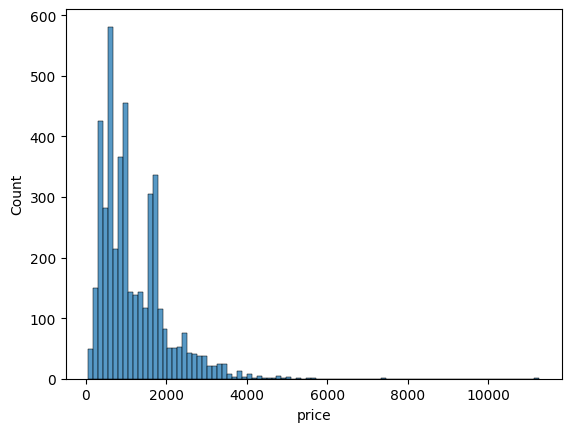

In [18]:
sns.histplot(data['price'])


cpu_speed  cpu_speed      1.000000
           price          0.521079
price      ram_gb         0.430854
ram_gb     harddisk_gb    0.367278
price      harddisk_gb    0.331461
cpu_speed  ram_gb         0.261671
           harddisk_gb   -0.068584
dtype: float64

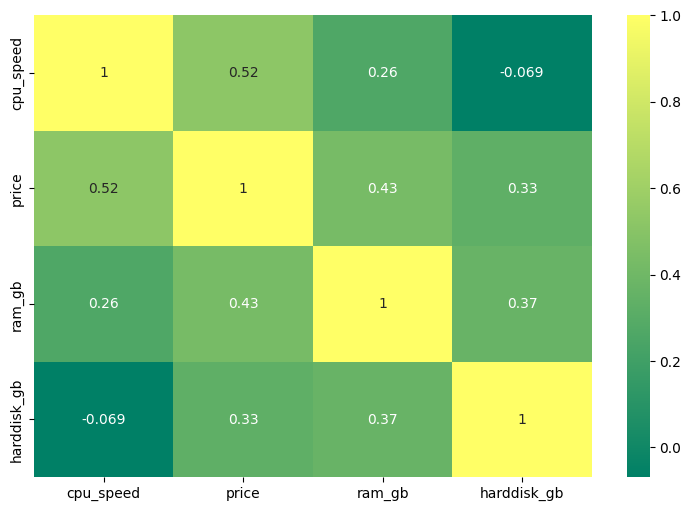

In [19]:
numeric_columns = list(data.dtypes[ data.dtypes == (float)].index)
numeric_df  = data[numeric_columns]
plt.figure(figsize=(9, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='summer')
numeric_df.corr().unstack().sort_values(ascending=False).drop_duplicates()


From the correlation matrix it seems clear that RAM size and CPU speed are most highly correlated with price. 

<Axes: >

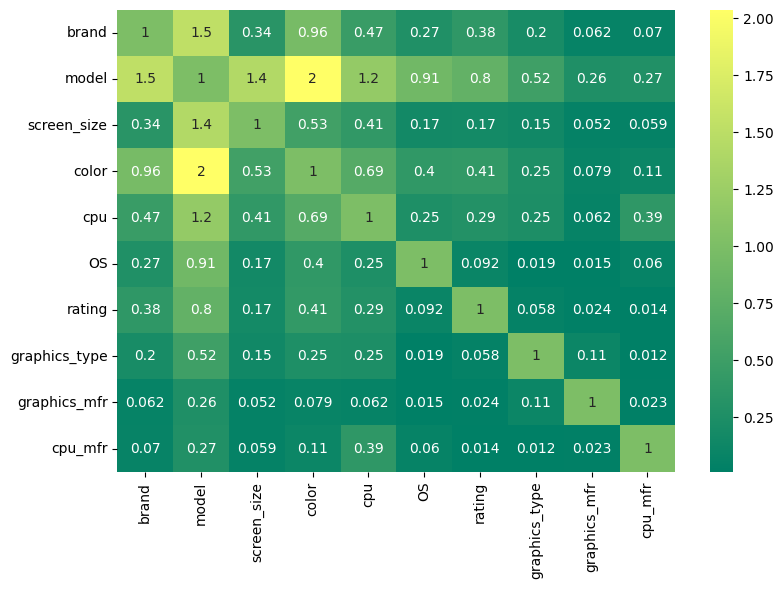

In [20]:
categorical_columns = list(data.dtypes[ data.dtypes == (object)].index)

df = data.copy()
for col in categorical_columns:
    df[col].fillna('unknown',inplace=True)
for col in numeric_columns:
    df[col].fillna(-1,inplace=True)
from sklearn.metrics import mutual_info_score
mutual_info = {}
for col1 in categorical_columns:
    row = {}
    for col2 in categorical_columns:
        if col1 == col2:
            row[col2] = 1
        else:
            row[col2] = mutual_info_score(df[col1], df[col2])
    mutual_info[col1] = row

mutual_info_df = pd.DataFrame(mutual_info)

plt.figure(figsize=(9, 6))
sns.heatmap(mutual_info_df, annot=True, cmap='summer')
        


There seems to be a strong connection between CPU and brand, as well as rating and brand

## Model selection process and parameter tuning


In [21]:
df = data.copy()
for feature in special_feature_column_names:
    df[feature] = df[feature].astype(str)

for col in categorical_columns:
    df[col].fillna('unknown',inplace=True)
for col in numeric_columns:
    df[col].fillna(0,inplace=True)
    # filling with the mean actually made the model worse
    # df[col].fillna(df[col].mean(),inplace=True)
    

df.reset_index(drop=True, inplace=True)


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error,r2_score

def train_linear_regression(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')
    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df_val, dv, model):
    dicts = df_val.to_dict(orient='records')
    X_val = dv.transform(dicts)
    
    y_pred = model.predict(X_val)
    
    return y_pred

# split data into train/val/test sets
def prepare(df):
    df = df.reset_index(drop=True)
    y = df['price'].values
    df = df.drop('price', axis=1)
    return df, y





In [23]:
# I tried various seed values and C values and these are the best results I got
# seed = 65
# C = 1.0
# here are some of the other seeds I tried and their rmse values
# 65	392.095953
# 29	401.938827
# 20	413.847958
# 18	418.447273
# 85	418.933517
# 25	419.334450
# 59	420.110480
# 39	420.604855
# 56	423.454367
# 16	424.669804


# scores = {}
SEED = 65
C= 1.0

df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=SEED)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=SEED)

df_train_full, y_train_full = prepare(df_train_full)
df_train, y_train = prepare(df_train)
df_val, y_val = prepare(df_val)
df_test, y_test = prepare(df_test)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

In [24]:
def remove_irrelevant_columns(df):
    #remove the color column since I don't feel like it contributes heavily to price
    df = df.drop('color', axis=1)
    #remove the model column since it is too distinct to generalize over 
    df = df.drop('model', axis=1)
    
    df = df.drop('cpu_speed', axis=1)
    df = df.drop('rating', axis=1)

    # get all the columns that start with sf_ and remove them 
    sf_columns = [col for col in df.columns if col.startswith('sf_')]
    df = df.drop(sf_columns, axis=1)
    return df

df_train = remove_irrelevant_columns(df_train)
df_train_full = remove_irrelevant_columns(df_train_full)

In [25]:
dv, model = train_linear_regression(df_train,y_train,C=C)
y_pred = predict(df_val,dv,model)

rmse = mean_squared_error(y_val,y_pred,squared=False)
rmse

384.8962966512167

In [26]:
# train for different values of C
for C in [0.001, 0.01, 0.1, 1, 10]:
    dv, model = train_linear_regression(df_train,y_train,C=C)
    y_pred = predict(df_val,dv,model)

    rmse = mean_squared_error(y_val,y_pred,squared=False)
    print(f'{C} RMSE {rmse}')

0.001 RMSE 384.8962966512167
0.01 RMSE 384.8962966512167
0.1 RMSE 384.8962966512167
1 RMSE 384.8962966512167
10 RMSE 384.8962966512167


In [27]:
scores = {}
for feature in df_train.columns:
    df_train_small = df_train.drop([feature], axis=1)
    dv, model = train_linear_regression(df_train_small,y_train,C=C)
    y_pred = predict(df_val,dv,model)

    new_rmse = mean_squared_error(y_val,y_pred,squared=False)
    scores[feature] = {
        'score': new_rmse,
        'diff_from_original': rmse - new_rmse
    }
    
scores_df = pd.DataFrame(scores).T
scores_df.sort_values(by='diff_from_original', ascending=True)

,score,diff_from_original
cpu,434.251529,-49.355232
brand,404.666371,-19.770075
harddisk_gb,402.309425,-17.413128
ram_gb,397.649889,-12.753592
graphics_type,395.969161,-11.072864
screen_size,393.240116,-8.343819
OS,392.951770,-8.055473
graphics_mfr,388.427242,-3.530946
bluetooth,385.808038,-0.911742
pen,385.782761,-0.886464


In [28]:

from sklearn.linear_model import Ridge

dicts = df_train.to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(dicts)
for a in [0, 0.01, 0.1, 1, 10,20,30,40,50,100]:
    model = Ridge(alpha=a)
    model.fit(X_train, y_train)
    X_val = dv.transform(df_val.to_dict(orient='records'))
    y_pred = model.predict(X_val)
    
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    print(a, round(score, 3))

0 394.174
0.01 394.168
0.1 394.122
1 393.674
10 391.44
20 390.019
30 389.716
40 390.072
50 390.821
100 398.343


A regular Linear Regression Model is better with an RMSE of 360 vs a Ridge of 389

In [29]:
df = data.copy()

categorical_columns = list(data.dtypes[ data.dtypes == (object)].index)
numeric_columns = list(data.dtypes[ data.dtypes == (float)].index)


for col in categorical_columns:
    df[col].fillna('unknown',inplace=True)
for col in numeric_columns:
    df[col].fillna(0,inplace=True)
    
df.reset_index(drop=True, inplace=True)

SEED = 65

df_train_full, df_test = train_test_split(df, test_size=0.2,random_state=SEED)
df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=SEED)

df_train_full, y_train_full = prepare(df_train_full)
df_train, y_train = prepare(df_train)
df_val, y_val = prepare(df_val)
df_test, y_test = prepare(df_test)

assert len(df) == (len(df_train) + len(df_val) + len(df_test))

Use Grid Search to find the best hyperparameters for XGBoost

In [30]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'max_depth': [6,7,8,9,10,11],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.2,0.5, 0.8,1.0],
    'colsample_bytree': [0.1,0.3,0.5],
    'min_child_weight': [0.4,0.5,1, 5],
}

# Create an instance of XGBRegressor
xgb_model = xgb.XGBRegressor()

# Create the grid search object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search object to the data
grid_search.fit(X_train, y_train)

# Get the best combination of hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Train the model with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_xgb_model.predict(X_val)

# Evaluate the model's performance
mse = mean_squared_error(y_val, y_pred,squared=False)
print("Mean Squared Error:", mse)
# best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 0.4, 'subsample': 0.2}

NameError: name 'xgb' is not defined

In [ ]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
import xgboost as xgb


features = dv.get_feature_names_out().tolist()
X_val = dv.transform(df_val.to_dict('records'))
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [ ]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'min_child_weight': 100,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'verbosity': 1,
    **best_params
}
model = xgb.train(xgb_params, dtrain, num_boost_round=50, evals=watchlist)


409.87763277947477


0.6799269276601688

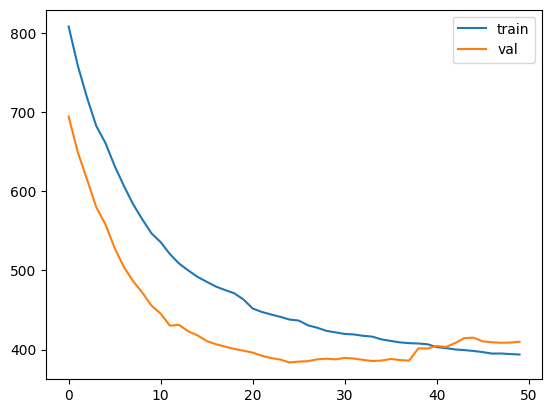

In [ ]:
df_score = parse_xgb_output(output)
plt.plot(df_score.num_iter, df_score.train_rmse, label='train')
plt.plot(df_score.num_iter, df_score.val_rmse, label='val')
# plt.ylim(0, 500)
plt.legend()
val_predict = model.predict(dval)
rmse = mean_squared_error(y_val, val_predict, squared=False)
print(rmse)
r2_score(y_val, val_predict)

Validate against test dataset

445.4707368095335


0.732690538617496

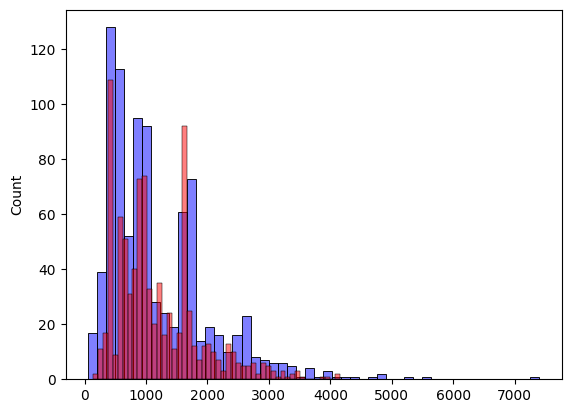

In [ ]:

xgb_params = {
    'eta': 0.1, 
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'verbosity': 1,
    **best_params
}

X_full_train = dv.fit_transform(df_train_full.to_dict(orient='records'))
features = dv.get_feature_names_out().tolist()

dfulltrain = xgb.DMatrix(X_full_train, label=y_train_full, feature_names=features)
X_test = dv.transform(df_test.to_dict(orient='records'))
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)
model = xgb.train(xgb_params, dfulltrain, num_boost_round=70)

test_predict = model.predict(dtest)

sns.histplot(y_test, color='blue', alpha=0.5, bins=50)
sns.histplot(test_predict, color='red', alpha=0.5, bins=50)
rmse = mean_squared_error(y_test, test_predict, squared=False)
print(rmse)
r2_score(y_test, test_predict)

402.6466288236133


0.7816143464271146

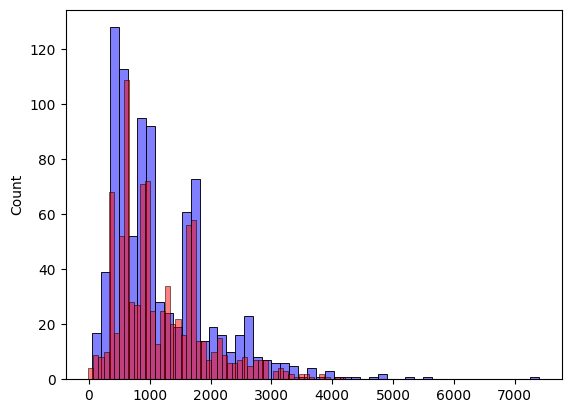

In [ ]:

dv, model = train_linear_regression(df_train_full,y_train_full,C=C)
test_predict = predict(df_test,dv,model)

sns.histplot(y_test, color='blue', alpha=0.5, bins=50)
sns.histplot(test_predict, color='red', alpha=0.5, bins=50)
rmse = mean_squared_error(y_test, test_predict, squared=False)
print(rmse)
r2_score(y_test, test_predict)

Normal Linear regression is the best overall model with a 403 on the test data set and an R2 of 0.78